In [1]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
import re
import requests

from sklearn.metrics import confusion_matrix,  multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [2]:
# Lists to store images data and labels
X = []
Y = []

# Input shape for ANN and also to resize images 
input_shape = (96, 96, 3)

# Merge train and test data into one dataset
# Loop through train and test subsets
for subset in ('train', 'test'):
    path_to_subset = f'data/{subset}'
    
    # Loop through all classes in subset
    for folder in os.listdir(path_to_subset):
        # Loop through all images in each class
        for image in os.listdir(os.path.join(path_to_subset, folder)):
            # Defining path to image
            path_to_image = os.path.join(path_to_subset, folder, image)
            # Reading image using cv2
            image = cv.imread(path_to_image)
            # Resizing image
            image = cv.resize(image, (input_shape[1], input_shape[0]))
            # Extracting labels from 'path_to_image' using regex
            # Appending data and labels to X and Y lists
            X.append(image)
            Y.append([folder])

# Convert X to numpy array and scale values between 0 and 1
X = np.array(X) / 255.0
Y = np.array(Y)
# Binarize labels
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(Y)

In [3]:
print(mlb.classes_)
print(Y[0])

["baldur's gate 3" 'btd6' 'content warning' 'csgo' 'cyber punk 2077'
 'darkest dungeon' 'fallout 3' 'fallout 4' 'fallout new vegas'
 'fnaf security breach' 'genshin impact' 'honkaistarrail' 'minecraft'
 'phasmophobia' 'slay the spire' 'terraria' 'valorant' 'wuthering waves'
 'yugioh master duel']
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [4]:
#split X and Y into it's training and testing sections

# test_x and test_y will be used for final predictions
x, test_x, y, test_y = train_test_split(X, Y, test_size = 0.1, stratify = Y, shuffle = True, random_state = 1)
# train_x, val_x, train_y, val_y will be used to train model and validate results during training
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 1)

#view the shape
print(x.shape, test_x.shape, y.shape, test_y.shape)
print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)

# use ImageDataGenerator to apply random transformations to images
datagen = ImageDataGenerator(rotation_range = 45,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split = 0.2)

(5613, 96, 96, 3) (624, 96, 96, 3) (5613, 19) (624, 19)
(4490, 96, 96, 3) (1123, 96, 96, 3) (4490, 19) (1123, 19)


In [5]:
# Creating model architecture
model = Sequential()

model.add(Conv2D(32, 3, padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 2, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.summary()

# use a *softmax* activation for single-label classification
# and *sigmoid* activation for multi-label classification
model.add(Dense(len(mlb.classes_), activation = 'sigmoid'))



c:\Users\ds\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:


# Checkpoint to save best model
checkpoint = ModelCheckpoint('models/best_model.keras', save_best_only = True, monitor = 'val_loss', verbose = 1)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(datagen.flow(train_x, train_y, batch_size = 64),
                             validation_data = (val_x, val_y), epochs = 100, verbose = 1, callbacks = [checkpoint])

Epoch 1/100


c:\Users\ds\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.1277 - loss: 0.8225
Epoch 1: val_loss improved from inf to 0.37103, saving model to models/best_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 529ms/step - accuracy: 0.1280 - loss: 0.8202 - val_accuracy: 0.0980 - val_loss: 0.3710
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.2378 - loss: 0.2623
Epoch 2: val_loss improved from 0.37103 to 0.20638, saving model to models/best_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 523ms/step - accuracy: 0.2384 - loss: 0.2617 - val_accuracy: 0.1736 - val_loss: 0.2064
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.3941 - loss: 0.1639
Epoch 3: val_loss improved from 0.20638 to 0.20352, saving model to models/best_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 522ms/step - accuracy: 0.3944 - loss: 0.1638 - val_accuracy: 0.2164 - val_loss: 0.2035
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.4747 - loss: 0.1463
Epoch 4: val_loss improved from 0.2035

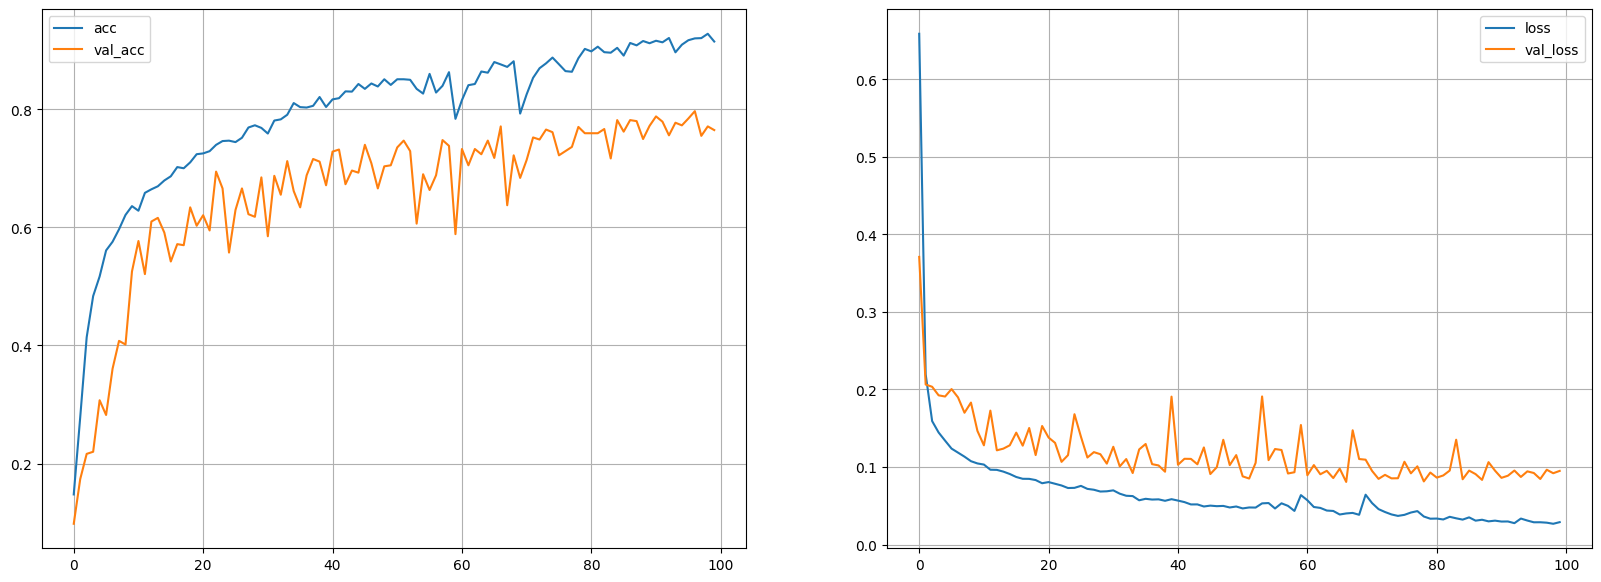

In [11]:
H = history.history
fig = plt.figure(figsize = (20, 7))
plt.subplot(121)
plt.plot(H['accuracy'], label = 'acc')
plt.plot(H['val_accuracy'], label = 'val_acc')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(H['loss'], label = 'loss')
plt.plot(H['val_loss'], label = 'val_loss')
plt.grid()
plt.legend()

In [8]:
import cv2
import imghdr
import tensorflow as tf

C:\Users\ds\AppData\Local\Temp\ipykernel_3944\3795465747.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [9]:
# Loading best weights
model.load_weights('models/best_model.keras')
# Save model for later usage
model.save('models/best_model.keras')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


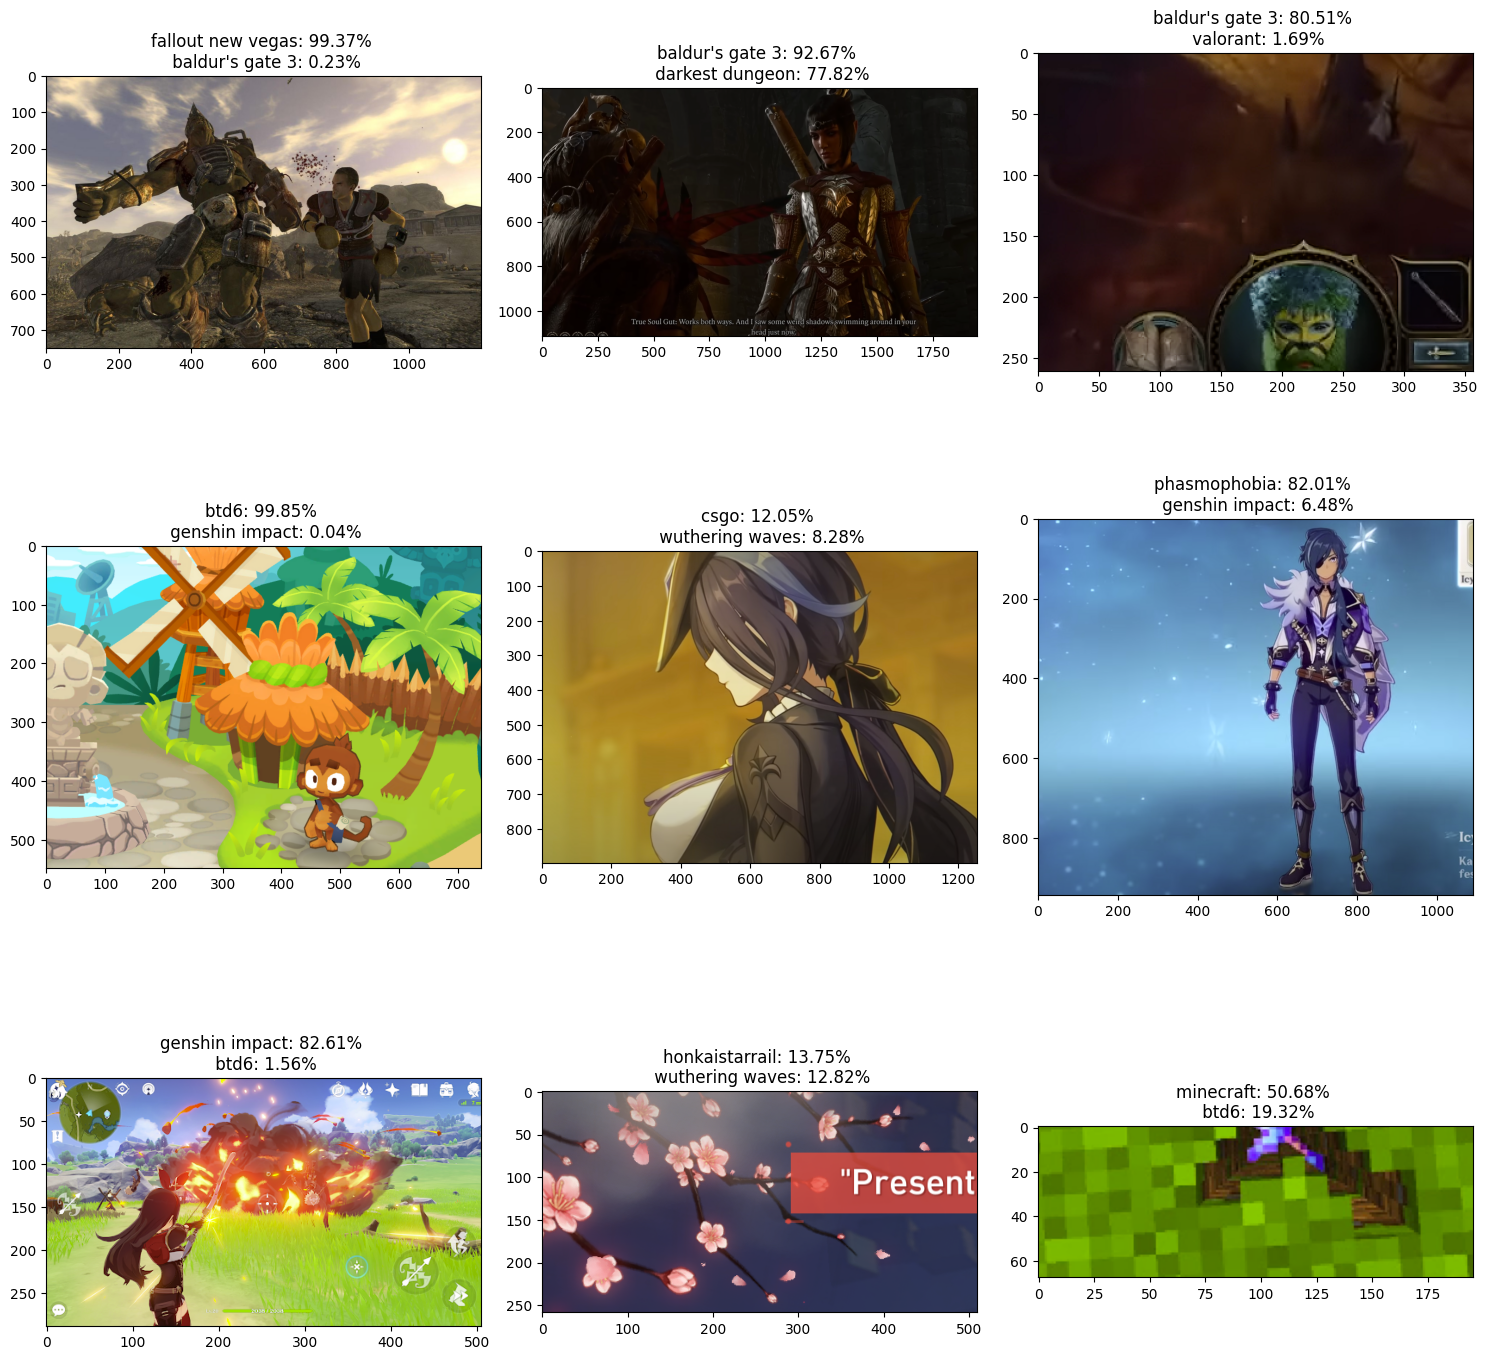

In [10]:

path_to_subset = f'single/'

# Loop through all classes in subset
    # Loop through all images in each class
fig = plt.figure(figsize = (15, 15))
i = 0
for image in os.listdir(os.path.join(path_to_subset)):
    plt.subplot(330 + i + 1)
    # Defining path to image
    path_to_image = os.path.join(path_to_subset, image)
    # Reading image using cv2
    image = cv.imread(path_to_image)
    # Resizing image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    resized = cv.resize(image, (input_shape[1], input_shape[0]))
    resized = (resized / 255.0).reshape(-1, input_shape[1], input_shape[0], input_shape[2])

    #make prediction
    yhat = model.predict(resized)
    preds = zip(list(mlb.classes_), list(yhat[0]))
    preds = sorted(list(preds), key = lambda z: z[1], reverse = True)[:2]
    plt.imshow(image[:, :, ::-1])
    plt.title(f'{preds[0][0]}: {round(preds[0][1] * 100, 2)}% \n {preds[1][0]}: {round(preds[1][1] * 100, 2)}%')
    i += 1
plt.tight_layout()